# Triangulation 

In [31]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
np.set_printoptions(linewidth=1000)
np.set_printoptions(threshold=np.inf)

from numpy.linalg import svd, norm, lstsq, inv, eigh, det, eigvalsh, eigvals
from tqdm.notebook import tqdm
import pandas as pd
import os
import pickle
import time
from datetime import datetime

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
%matplotlib widget
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.set_option('display.max_rows', 500)


def pprint(array, precision=4):
    with np.printoptions(
        precision=precision,
        suppress=True,
        # formatter={'float': lambda x: "{res:.3e}".format(res=x)}
    ):
        print(array)
    

def load_pickle(file_name):
    with open(file_name, 'rb') as pfile:
        return pickle.load(pfile)


from geometry_utils import triangulation
from simulation_experiments import default_solver_params
import plot_reconstruction
from plot_reconstruction import plot_problem, plot_point, ydown2zup
import blender_plots as bplt
from blender_plots import blender_utils as bu
import bpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example problem
Start by generating an example problem

In [3]:
n_poses = 5
n_outliers = 2
observation_noise = 15

height, width = 1162, 2108
K = np.array([
    [1012.0027, 0, 1054],
    [0., 1012.0027, 581],
    [0., 0., 1.],
])
K = np.array([K for _ in range(n_poses)])

problem = triangulation.get_aholt_problem(n_poses, mode="sphere", K=K, angle_jitter_deg=10)

observations = problem.get_observations(sigma=observation_noise)
observations, inlier_mask = triangulation.add_outliers(observations, n_outliers, 10, 10)
gt_observations = problem.get_observations(sigma=0)

plot_reconstruction.setup_scene()
plot_problem(
    poses=problem.poses,
    observations=observations,
    intrinsics=K,
    shapes=[[height, width] for _ in range(n_poses)],
    image_depth=0.25,
    inlier_mask=inlier_mask
)
plot_point(problem.point, color=[0, 0, 1], name='gt point')

100%|██████████| 5/5 [00:00<00:00, 194.19it/s]


Solve with non-robust relaxation

In [4]:
## epipolar method
# sdr = triangulation.TriangulationSDR(problem.poses, observations, problem.K, scale=1/1054.)

## fractional method
sdr = triangulation.TriangulationFractionalSDR(problem.poses, observations, problem.K, scale=1/1054.)

sdr.solve(solver="MOSEK", **default_solver_params["MOSEK"])
results = sdr.get_solution()
plot_point(results["estimated_point"], color=[1, 0, 0], name='sdr non-robust')

print('First 5 singular values:', [results[f's{i}'] for i in range(5)])
print('error:', norm(problem.point - results["estimated_point"]))

First 5 singular values: [7.8506104599645825, 7.093895009025201e-14, 3.5741266055831126e-14, 2.0253093891149486e-14, 1.3526758821827634e-14]
error: 1.197025293311293


Solve with robust relaxation

In [5]:
## epipolar method
# sdr = triangulation.RobustTriangulationSDR(problem.poses, observations, problem.K, scale=1/1054.)

## fractional method (using smaller scale, otherwise non-robust fractional relaxation often throws error from MOSEK - not sure why)
sdr = triangulation.RobustTriangulationFractionalSDR(problem.poses, observations, problem.K, scale=1/1054.)

sdr.solve(solver="MOSEK", **default_solver_params["MOSEK"])
results = sdr.get_solution()
plot_point(results["estimated_point"], color=[0, 1, 0], name='sdr robust')

print('First 5 singular values:', [results[f's{i}'] for i in range(5)])
print('Estimated inlier mask:', results["estimated_inlier_mask"])

First 5 singular values: [6.137226399172713, 3.5473684074236823e-10, 7.836350660099213e-11, 4.741753062002176e-11, 4.741573055317433e-12]
Estimated inlier mask: [False False  True False  True]


##  Plots for paper

### Noise plot

In [8]:
experiment_dir = Path("/home/linus/workspace/convex_relaxations/results")
base_dirs = [experiment_dir / p for p in [
    ## for camera ready
    "3_5_7_views_constraints_comparison-updated_algtri/0301_175855",
    "3_5_7_views_constraints_comparison-updated_algtri/0301_165431/",
    "3_5_7_views_fractional_constraints_comparison-updated_algtri/0302_142800/",
    "3_5_7_views_fractional_constraints_comparison-updated_algtri/0302_145945/",    
    "3_5_7_views_fractional_constraints_comparison-updated_algtri/0302_151118/",    
    "3_5_7_views_fractional_constraints_comparison-updated_algtri/0302_152256/",    
    ## for camera ready, more views
    # "25_30_views_constraints_comparison-updated_algtri/0304_151117",
    # "25_30_views_constraints_comparison-updated_algtri/0304_151123",
    # "25_30_views_constraints_comparison-updated_algtri/0304_151125",
    ## updated results
    # r'3_5_7_views_rerun_fractional/0212_124018',
    # r'3_5_7_views_rerun/0211_180109',
    ## first version of results
    # large plot
    # 'sweep_epipolar_noparam_mosek/1109_161139',
    # 'sweep_all_noparam_mosek/1109_222125',
    # small plot
    # 'sweep_all_noparam_mosek_moreviews/1111_144041',
    # 'sweep_all_noparam_mosek_moreviews/1111_172357',
    # 'sweep_all_noparam_mosek_moreviews_30/1111_172751',
]]

def load_results(base_dir):
    n_files = len([f for f in os.listdir(base_dir) if 'results' in f])
    results = pd.concat([load_pickle(Path(base_dir) / f'results{i}.pickle') for i in range(n_files)])
    return results

results = pd.concat([load_results(base_dir).assign(base_dir=base_dir) for base_dir in base_dirs]).reset_index()

In [9]:
print('n_epipolar:', len(results[results.method == "robust_epipolar"][['trial_index', 'base_dir']].value_counts()))
print('n_fractional:', len(results[results.method == "robust_fractional"][['trial_index', 'base_dir']].value_counts()))

/tmp/tmppk05b5hq/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


n_epipolar: 750
n_fractional: 120


/tmp/tmppk05b5hq/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


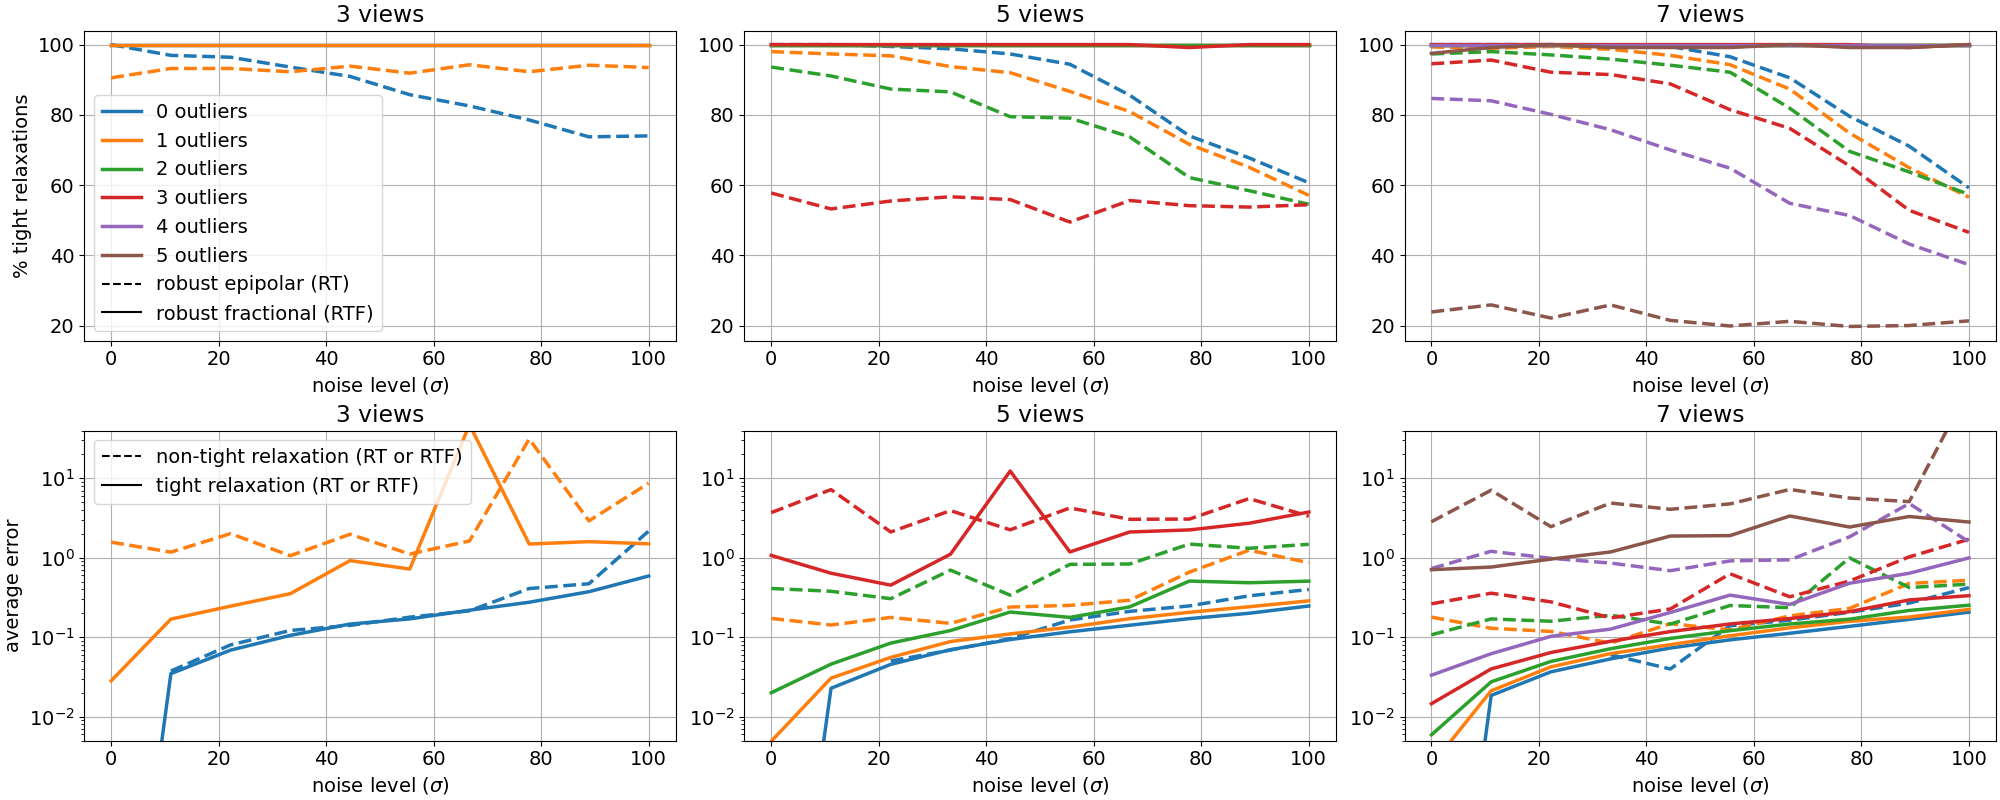

Info: Deleted 2 object(s)

Info: Deleted 1 object(s)

Info: Deleted 1 object(s)



In [10]:
results["point_error"] = results.apply(lambda r: norm(r.problem.point - r.estimated_point), axis=1)
style = {
    'robust_epipolar': '--',
    'robust_fractional': '-'
}
markersize = 5
names = {
    'epipolar': 'epipolar (T)',
    'fractional': 'fractional (TF)',
    'robust_epipolar': 'robust epipolar (RT)',
    'robust_fractional': 'robust fractional (RTF)',
}

results["tight_relaxation"] = results.apply(lambda r: r.s1 < 1e-4 and (r.s_algebraic[-1] < 1e-6 if r.method == "robust_epipolar" else True), axis=1)

matplotlib.rcParams.update({'font.size': 14})
linewidth = 2.5

fig, ax = plt.subplots(
    2, len(results.n_poses.unique()), sharex=True, sharey="row",
    # figsize=(15, 12),
    figsize=(20, 8),
    layout='constrained'
)
ax = np.array(ax).reshape((2, len(results.n_poses.unique())))

for (n_poses, n_outliers), sub_table_allmethods in results[results.with_inequalities].groupby(["n_poses", "n_outliers"]):
    ax_index = list(results.n_poses.unique()).index(n_poses)
    for method, sub_table in sub_table_allmethods.groupby('method'):
        if "robust" in method:
            ax[0, ax_index].set_title(f"{n_poses} views")
            ax[0, ax_index].plot(
                sub_table["observation_noise"].unique(),
                [noise_table.tight_relaxation.mean() * 100 for _, noise_table in sub_table.groupby('observation_noise')],
                linestyle=style[method],
                color=mpl_colors[list(results.n_outliers.unique()).index(n_outliers)],
                linewidth=linewidth,
                markersize=markersize
            )
        if 'epipolar' in method:
            non_tight = sub_table[~sub_table.tight_relaxation].sort_values("observation_noise")
            ax[1, ax_index].semilogy(
                non_tight["observation_noise"].unique(),
                [noise_table.point_error.mean() for _, noise_table in non_tight.groupby('observation_noise')],
                linestyle='--',
                color=mpl_colors[list(results.n_outliers.unique()).index(n_outliers)],
                linewidth=linewidth,
                markersize=markersize,
            )
    ax[1, ax_index].set_title(f'{n_poses} views')
    tight = sub_table_allmethods[sub_table_allmethods.tight_relaxation].sort_values("observation_noise")
    ax[1, ax_index].semilogy(
        tight["observation_noise"].unique(),
        [noise_table.point_error.mean() for _, noise_table in tight.groupby('observation_noise')],
        linestyle='-',
        color=mpl_colors[list(results.n_outliers.unique()).index(n_outliers)],
        linewidth=linewidth,
        markersize=markersize,
    )

    
for a in ax.reshape(-1):
    a.set_xlabel(r'noise level ($\sigma$)')
    a.yaxis.set_tick_params(labelbottom=True)
    a.xaxis.set_tick_params(labelbottom=True)
    a.grid(axis='both')

for i, n_outliers in enumerate(sorted(results.n_outliers.unique())):
    ax[0, -1].plot([], [], color=mpl_colors[i], linestyle='-', label=f'{n_outliers} outliers', linewidth=linewidth)
ax[0, -1].plot([], [], color='k', linestyle=style["robust_epipolar"], label=names['robust_epipolar'], marker='', markersize=markersize)
ax[0, -1].plot([], [], color='k', linestyle=style["robust_fractional"], label=names['robust_fractional'], marker='', markersize=markersize)
    
ax[1, 0].plot([], [], color='k', linestyle='--', marker='', label='non-tight relaxation (RT or RTF)', markersize=markersize)
ax[1, 0].plot([], [], color='k', linestyle='-', marker='', label='tight relaxation (RT or RTF)', markersize=markersize)
ax[1, 0].legend(loc='upper left')

 
ax[0, 0].set_ylabel('% tight relaxations')
    
for a in ax[1, :]:
    a.set_ylim(
        5e-3, 
        4e1
        # 7
        # a.get_ylim()[1]
    )
ax[1, 0].set_ylabel('average error')
# ax[2, 0].set_ylabel('average error\nnon-tight relaxation')

legend = ax[0, -1].legend()
ax[0, 0].legend(legend.get_lines(), [s._text for s in legend.get_texts()])
legend.remove()

In [64]:
date_format = r'%m%d_%H%M%S'
fig.savefig(f'results_simulations_3_5_7_{datetime.now().strftime(date_format)}.pdf', bbox_inches='tight')

### Coplanar statistics

/tmp/ipykernel_11673/4015111737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epipolar["coplanar_solution"] = (epipolar.s1 < 1e-4) & (epipolar.s_algebraic.apply(lambda s: s[-1] > 1e-6))


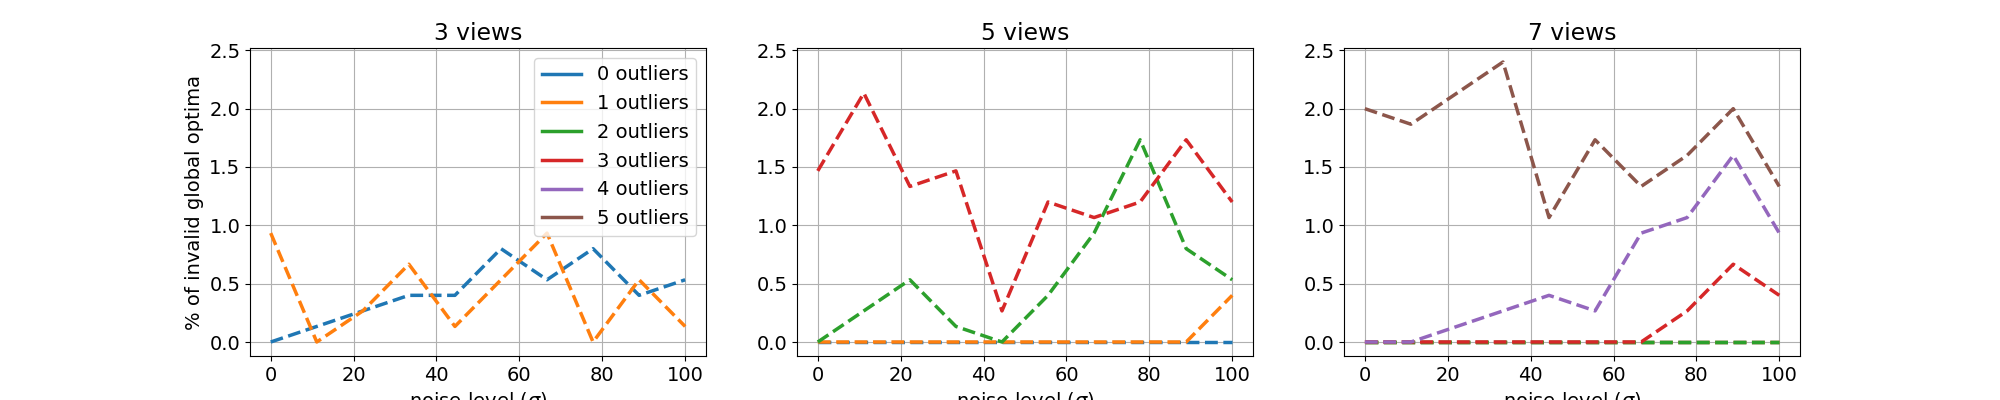

In [11]:
epipolar = results[(results.method == "robust_epipolar")]
epipolar["coplanar_solution"] = (epipolar.s1 < 1e-4) & (epipolar.s_algebraic.apply(lambda s: s[-1] > 1e-6))

linewidth = 2.5
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(
    1, len(results.n_poses.unique()), sharex=True, sharey="row",
    figsize=(20, 4),
)

for (n_poses, n_outliers), sub_table_allmethods in epipolar[epipolar.with_inequalities].groupby(["n_poses", "n_outliers"]):
    ax_index = list(epipolar.n_poses.unique()).index(n_poses)
    for method, sub_table in sub_table_allmethods.groupby('method'):
        if "robust" in method:
            ax[ax_index].set_title(f"{n_poses} views")
            ax[ax_index].plot(
                sub_table["observation_noise"].unique(),
                [noise_table.coplanar_solution.mean() * 100 for _, noise_table in sub_table.groupby('observation_noise')],
                linestyle="--",
                color=mpl_colors[list(results.n_outliers.unique()).index(n_outliers)],
                linewidth=linewidth,
            )
for i, n_outliers in enumerate(sorted(results.n_outliers.unique())):
    ax[0].plot([], [], color=mpl_colors[i], linestyle='-', label=f'{n_outliers} outliers', linewidth=linewidth)
ax[0].legend()
ax[0].set_ylabel('% of invalid global optima')
for a in ax:
    a.yaxis.set_tick_params(labelbottom=True)
    a.xaxis.set_tick_params(labelbottom=True)
    a.grid(axis='both')
    a.set_xlabel(r'noise level ($\sigma$)')

In [53]:
date_format = r'%m%d_%H%M%S'
fig.savefig(f'coplanar_stats_{datetime.now().strftime(date_format)}.pdf', bbox_inches='tight')

In [23]:
sub_results = results[(results.method == 'robust_epipolar') & results.with_inequalities]
r = sub_results[
    sub_results.s_algebraic.apply(lambda s: s[-1] > 0.1) & (sub_results.s1 < 1e-4) & (sub_results.n_poses == 3) & sub_results.with_inequalities & (sub_results.observation_noise < 5)
].iloc[3]
sdr_observations = r.X[:-1, -1].reshape((r.n_poses, 3))[r.estimated_inlier_mask][:, :2] * 1054

plot_reconstruction.setup_scene(floor_z=-2.2, resolution=(1363, 1363), sun_energy=1.)
plot_problem(
    r.problem.poses,
    # r.observations,
    sdr_observations,
    np.array([r.problem.K for _ in range(r.n_poses)]),
    [(1162, 2108) for _ in range(r.n_poses)],
    0.25,
    # inlier_mask=r.inlier_mask,
)
plot_point(r.problem.point, color=[0, 0, 1], name="point")
plot_point(r.estimated_point, color=[0, 1, 0], name=f"point sdr ({r.method})")

for i in range(3):
    for j in range(i+1, 3):
        point, _ = triangulation.triangulate_algebraic(
            sdr_observations[[i, j]],
            r.problem.poses[[i, j]],
            np.array([r.problem.K for _ in range(2)]),
        )
        plot_point(point, color=[0, 0, 0], name=f'intersection_{i}{j}', point_radius=0.04)

100%|██████████| 3/3 [00:00<00:00, 333.78it/s]


### COLMAP data

3D visualization

In [35]:
def params_to_intrinsics(pars):
    return np.array([[pars[0], 0, pars[2]], [0, pars[1], pars[3]], [0, 0, 1]])

def get_intrinsics(camera):
    pars = camera.params
    if camera.model == 'SIMPLE_RADIAL':
        return np.array([
            [pars[0], 0, pars[1]],
            [0, pars[0], pars[2]],
            [0, 0, 1],
        ])
    else:
        return params_to_intrinsics(pars)

# load reconstruction from colmap
from colmap.scripts.python.read_write_model import read_model, qvec2rotmat

dataset = "reichstag"
src = f'/home/linus/workspace/data/image_matching/{dataset}'
src = str(Path('/home', 'linus', 'workspace', 'data', dataset, 'dense', 'sparse'))
# src = os.path.dirname(log_path) + '/0'
cameras, images, points = read_model(path=src, ext='.bin')

print(f'Cameras: {len(cameras)}')
print(f'Images: {len(images)}')
print(f'3D points: {len(points)}')

indices = [i for i in cameras]

Cameras: 75
Images: 75
3D points: 17823


In [38]:
from geometry_utils.se3 import Se3

bpy.data.worlds["World"].node_tree.nodes["Background"].inputs[0].default_value = (1, 1, 1, 1)
bpy.context.scene.render.engine = 'CYCLES'


colmap_points = np.array([ydown2zup[:3, :3] @ point.xyz for point in points.values()])
colmap_colors = np.array([point.rgb / 255. for point in points.values()])

view_inds = sorted(images.keys())
r = np.array([qvec2rotmat(images[i].qvec) for i in view_inds])
t = np.array([images[i].tvec for i in view_inds])
colmap_poses = Se3(ydown2zup[:3, :3]) * Se3(r, t).inverse()

bplt.Scatter(colmap_points, color=colmap_colors, marker_type='spheres', name='colmap points', radius=0.01)

outlier plot

In [24]:
experiment_dir = Path("/home", "linus", "workspace", "convex_relaxations", "results")
base_dirs = [experiment_dir / p for p in [
    'reichstag_3_5_7_outliers/0305_152337',
    'reichstag_3_5_7_outliers/0305_152340',
    'reichstag_3_5_7_outliers/0305_152407',
    'reichstag_25_30_outliers/0310_112255',
    'reichstag_25_30_outliers/0310_112304',
    'reichstag_25_30_outliers/0310_112341',
]]

def load_results(base_dir):
    n_files = len([f for f in os.listdir(base_dir) if 'results' in f])
    results = pd.concat([load_pickle(Path(base_dir) / f'results{i}.pickle') for i in range(n_files)])
    return results

results = pd.concat([load_results(base_dir).assign(base_dir=base_dir) for base_dir in base_dirs]).reset_index()
results["error"] = results.apply(lambda r: norm(r.estimated_point - ydown2zup[:3, :3] @ r.problem.point) if r.n_poses < 10 else r.error, axis=1) # fix for when ydown2zup wasn't applied

/tmp/tmppk05b5hq/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


In [25]:
for method in results.method.unique():
    print(f'{method}:', len(results[results.method == method][['trial_index', 'base_dir']].value_counts()))

robust_epipolar: 1305
robust_fractional: 180


/tmp/tmppk05b5hq/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


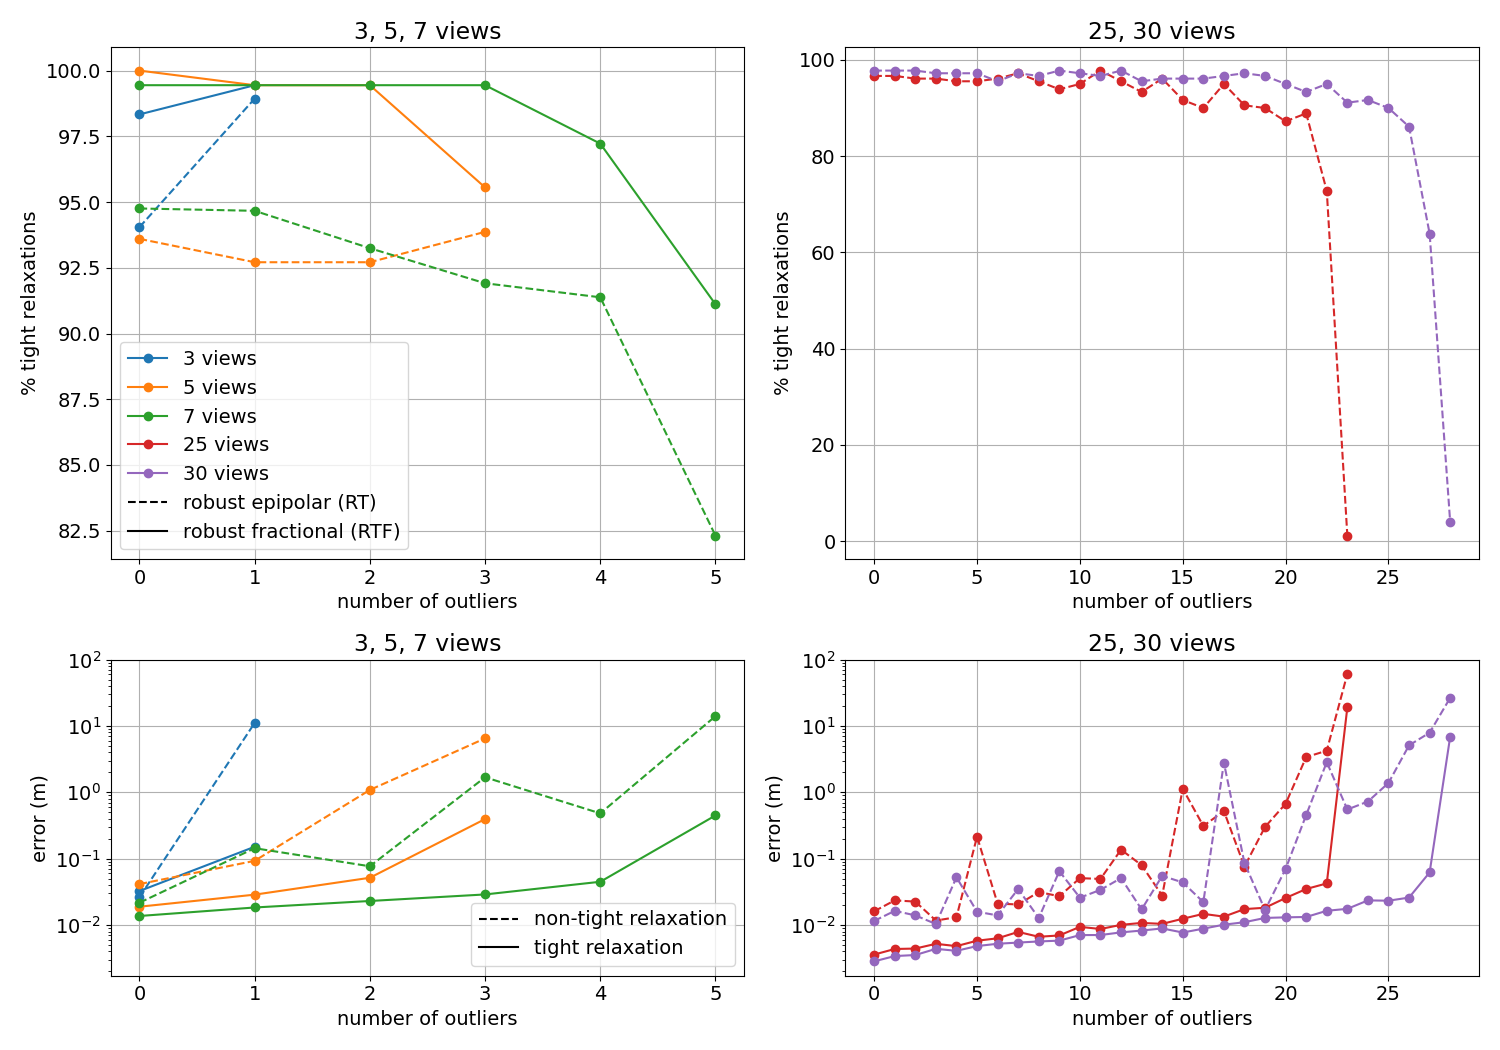

In [26]:
names = {
    'epipolar': 'epipolar (T)',
    'fractional': 'fractional (TF)',
    'robust_epipolar': 'robust epipolar (RT)',
    'robust_fractional': 'robust fractional (RTF)',
}

style = {
    # 'epipolar': '--',
    # 'fractional': '-',
    'robust_epipolar': '--',
    'robust_fractional': '-',
}
results['success'] = results.s1 < 1e-4

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

results["tight_relaxation"] = results.apply(lambda r: r.s1 < 1e-4 and (r.s_algebraic[-1] < 1e-6 if r.method == "robust_epipolar" else True), axis=1)

fig, ax = plt.subplots(2, 2, figsize=(15, 10.5), gridspec_kw={'height_ratios': [1.618, 1]})
for n_views, sub_table in results.groupby('n_views'):
    ax_index = 0 if n_views < 10 else 1
    color = mpl_colors[list(results.n_views.unique()).index(n_views)]
    for method, method_table in sub_table.groupby("method"):
        ax[0, ax_index].plot(
            method_table.n_outliers.unique(),
            method_table.groupby('n_outliers').tight_relaxation.mean() * 100,
            linestyle=style[method],
            color=color,
            label=f'{n_views} views' if style[method] == '-' else None,
            marker='o',
            alpha=1,
        )
    results_tight = sub_table[sub_table.tight_relaxation].sort_values('n_outliers')
    ax[1, ax_index].semilogy(
        results_tight.n_outliers.unique(),
        results_tight.groupby('n_outliers').error.mean(),
        linestyle='-',
        color=color,
        # label=f'{n_views} views' if style[method] == '-' else None,
        marker='o',
        alpha=1,
    )
    results_nontight = sub_table[~sub_table.tight_relaxation].sort_values('n_outliers')
    ax[1, ax_index].semilogy(
        results_nontight.n_outliers.unique(),
        results_nontight.groupby('n_outliers').error.mean(),
        linestyle='--',
        color=color,
        # label=f'{n_views} views' if style[method] == '-' else None,
        marker='o',
        alpha=1,
    )

    if ax_index != 0:
        ax[0, 0].plot([], [], color=color, label=f'{n_views} views', marker='o')

for method, linestyle in style.items():
    ax[0, 0].plot([], [], linestyle, color='k', label=names[method])
ax[0, 0].legend()

ax[1, 0].plot([], [], 'k--', label='non-tight relaxation')
ax[1, 0].plot([], [], 'k-', label='tight relaxation')
ax[1, 0].legend(loc='lower right')
# handles, labels = ax[0, 0].get_legend_handles_labels()
# order = [2, 3, 4, 0, 1, 5, 6]
# ax[0, 0].legend([handles[i] for i in order], [labels[i] for i in order])
for a in ax[0]:
    # a.legend()
    # ax.set_ylim(0, 1.1)
    a.grid('on')
    a.set_xlabel('number of outliers')
    a.set_ylabel('% tight relaxations')
    a.yaxis.set_tick_params(labelbottom=True)
    a.xaxis.set_tick_params(labelbottom=True)
    
for a in ax[1]:
    a.grid('on')
    a.set_xlabel('number of outliers')
    a.set_ylabel('error (m)')
    a.yaxis.set_tick_params(labelbottom=True)
    a.xaxis.set_tick_params(labelbottom=True)

for a in ax[:, 0]:
    a.set_title('3, 5, 7 views')
for a in ax[:, 1]:
    a.set_title('25, 30 views')
ax[1, 0].set_ylim(ax[1, 1].get_ylim())
plt.tight_layout()

In [49]:
date_format = r'%m%d_%H%M%S'
fig.savefig(f'results_colmap_fix-tri_with-inequalities_{datetime.now().strftime(date_format)}.pdf', bbox_inches='tight')

plot example problem

In [40]:
r = results[(results.n_outliers == 0) & (results.method == "robust_fractional")].iloc[0]
plot_problem(
    r.problem.poses,
    r.observations,
    r.problem.K,
    [(1162, 2108) for _ in range(r.n_poses)],
    0.25,
    inlier_mask=r.inlier_mask,
)
plot_point(r.problem.point, color=[0, 0, 1], point_radius=0.1)

100%|██████████| 3/3 [00:00<00:00, 82.61it/s]


## Simulated RANSAC

In [7]:
def full_ransac(poses, observations, intrinsics, inlier_threshold):
    n_views = len(poses)
    results = []
    for i in range(n_views-1):
        for j in range(i+1, n_views):
            sdr = triangulation.TriangulationSDR(
                poses[[i, j]],
                observations[[i, j]],
                intrinsics,
                scale=1/1054.,
            )
            try:
                sdr.solve(solver='MOSEK', verbose=False, mosek_params={'MSK_DPAR_INTPNT_CO_TOL_REL_GAP': 1e-14})
            except cvxpy.SolverError:
                sdr.solve(solver='MOSEK', verbose=False, mosek_params={'MSK_DPAR_INTPNT_CO_TOL_REL_GAP': 1e-10})
            sdr_solution = sdr.get_solution()
            estimated_point = sdr_solution['estimated_point']
            eps = norm(geometry.reproject(estimated_point, poses, intrinsics) - observations, axis=1)**2
            estimated_inlier_mask = eps < inlier_threshold
            cost = eps[estimated_inlier_mask].sum() + (~estimated_inlier_mask).sum() * inlier_threshold
            results.append({
                'i': i,
                'j': j,
                'point': estimated_point,
                'cost': cost,
                'inlier_mask': estimated_inlier_mask,
            })
    return pd.DataFrame(results)
ransac_results = []
sub_results = results[(results.method == "robust_epipolar") & results.with_inequalities & (results.trial_index <= 4)]
for i, r in tqdm(sub_results.iterrows(), total=len(sub_results)):
    ransac_result = full_ransac(r.problem.poses, r.observations, r.problem.K, 200 ** 2)
    ransac_results.append(ransac_result)

  0%|          | 0/1050 [00:00<?, ?it/s]

In [10]:
date_format = r'%m%d_%H%M%S'
with open(f'results_with_ransac_25_30_{datetime.now().strftime(date_format)}.pickle', 'wb') as pickle_file:
    pickle.dump((sub_results, ransac_results), pickle_file)

In [5]:
# def robust_cost(point, poses, intrinsics, observations, c):
#     square_norms = norm(geometry.reproject(point, poses, intrinsics) - observations, axis=1)**2
#     square_norms[square_norms > c] = c
#     return square_norms.sum()
# sub_results["cost"] = sub_results[sub_results.method.apply(lambda m: "robust" in m)].apply(lambda r: robust_cost(r.results[0], r.problem.poses, r.problem.K, r.observations, 200**2), axis=1)
# sub_results["ransac_success"] = [(ransac_results[i].inlier_mask.apply(lambda mask: (mask == sub_results.iloc[i].inlier_mask).all())).any() for i in tqdm(range(len(sub_results)))]
sub_results["ransac_cost"] = [ransac_results[i].cost.min() for i in tqdm(range(len(sub_results)))]
sub_results["ransac_point"] = [ransac_results[i].loc[ransac_results[i].cost.argmin()].point for i in tqdm(range(len(sub_results)))]
sub_results["ransac_inliers"] = [ransac_results[i].loc[ransac_results[i].cost.argmin()].inlier_mask for i in tqdm(range(len(sub_results)))]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

/tmp/tmpk0yzgwfn/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


In [6]:
def f(i):
    best_ransac = ransac_results[i].loc[ransac_results[i].cost.argmin()]
    r = sub_results.iloc[i]
    nl_point, nl = triangulation.triangulate_nonlinear(
        r.problem.poses[best_ransac.inlier_mask],
        r.observations[best_ransac.inlier_mask],
        r.problem.K,
        best_ransac.point,
    )
    return triangulation.robust_cost(nl_point, r.problem.poses, r.observations, r.problem.K, np.array([200**2 for _ in range(r.n_poses)]))
sub_results["ransac_cost_refined"] = [f(i) for i in range(len(sub_results))]
sub_results["ransac_cost_best"] = sub_results.apply(lambda r: min(r.ransac_cost, r.ransac_cost_refined) if r.ransac_inliers.sum() >= 2 else r.ransac_cost, axis=1)

/tmp/tmpk0yzgwfn/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


In [7]:
sub_results["cost_refined"] = sub_results.apply(lambda r: triangulation.robust_cost(
    triangulation.triangulate_nonlinear(
        r.problem.poses[r.estimated_inlier_mask],
        r.observations[r.estimated_inlier_mask],
        r.problem.K,
        r.estimated_point
    )[0] if sum(r.estimated_inlier_mask) > 0 else r.estimated_point,
    r.problem.poses, r.observations, r.problem.K, np.array([200**2 for _ in range(r.n_poses)])
), axis=1)

sub_results["point_refined"] = sub_results.apply(lambda r: triangulation.triangulate_nonlinear(
    r.problem.poses[r.estimated_inlier_mask],
    r.observations[r.estimated_inlier_mask],
    r.problem.K,
    r.estimated_point
)[0] if sum(r.estimated_inlier_mask) > 0 else r.estimated_point, axis=1)
sub_results["cost_best"] = sub_results.apply(lambda r: min(r.cost, r.cost_refined) if r.ransac_inliers.sum() >= 2 else r.cost, axis=1)

/tmp/tmpk0yzgwfn/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


In [11]:
date_format = r'%m%d_%H%M%S'
with open(f'results_with_ransac_25_30_{datetime.now().strftime(date_format)}.pickle', 'wb') as pickle_file:
    pickle.dump((sub_results, ransac_results), pickle_file)

/tmp/ipykernel_415022/1445629874.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_results["tight_relaxation"] = sub_results.apply(lambda r: r.s1 < 1e-4 and (r.s_algebraic[-1] < 1e-6 if r.method == "robust_epipolar" else True), axis=1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


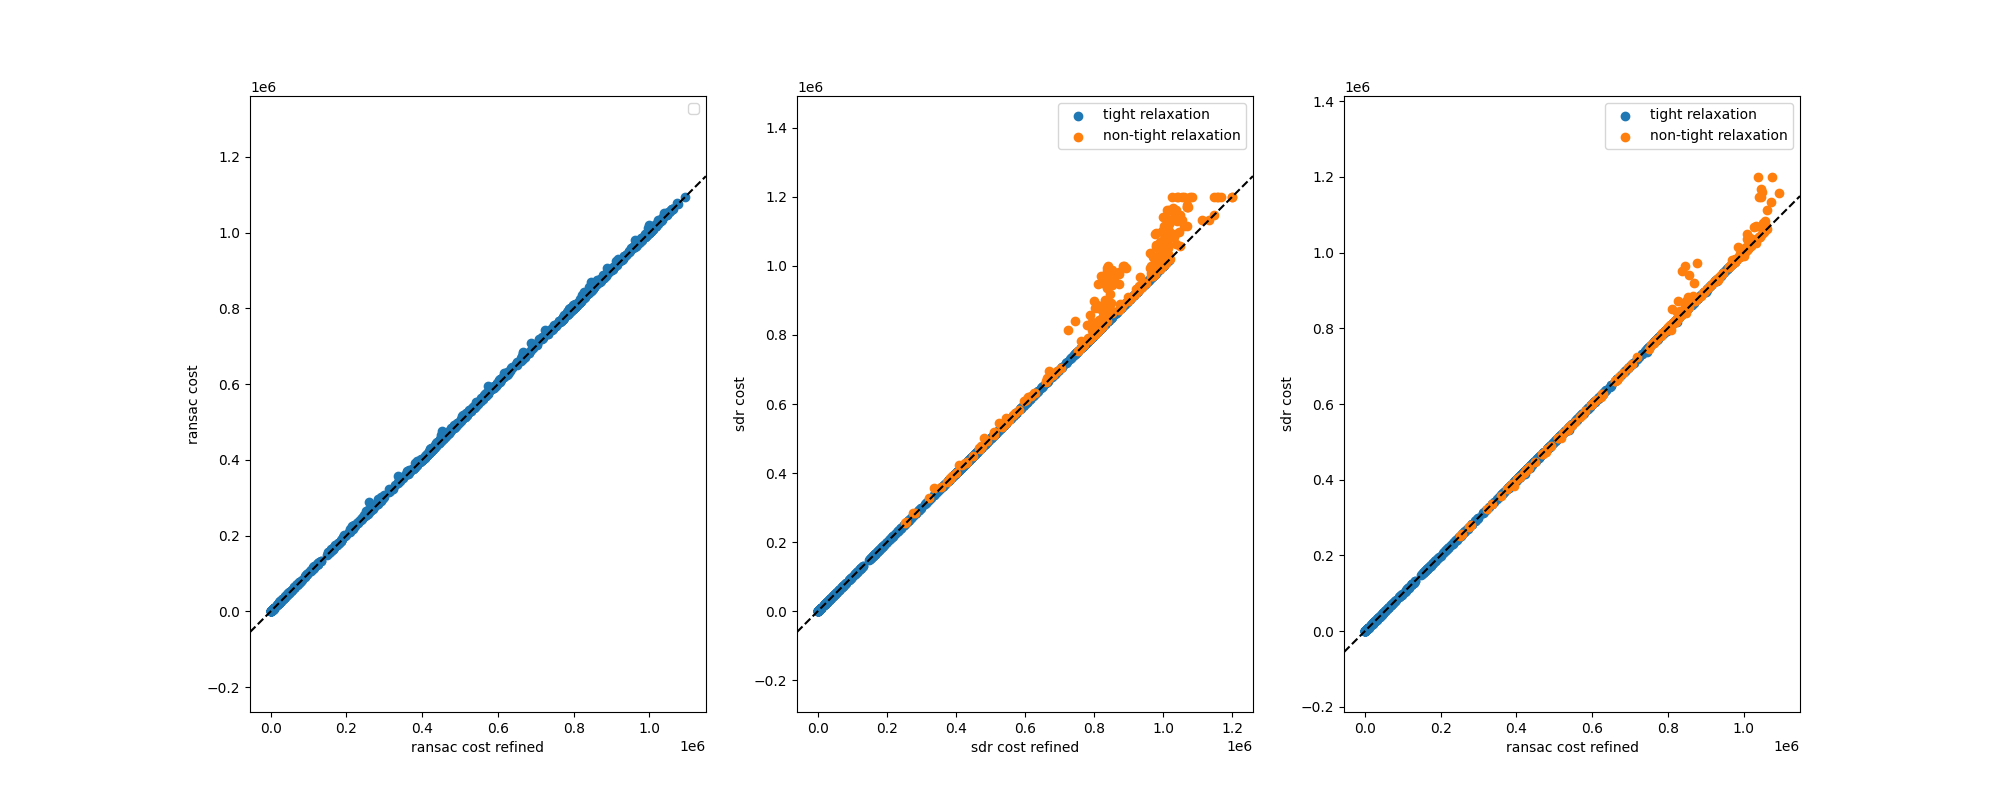

/tmp/tmpui3b0izt/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].scatter(sub_results.ransac_cost_refined, sub_results.ransac_cost)
ax[0].set_xlabel('ransac cost refined')
ax[0].set_ylabel('ransac cost')

sub_results["tight_relaxation"] = sub_results.apply(lambda r: r.s1 < 1e-4 and (r.s_algebraic[-1] < 1e-6 if r.method == "robust_epipolar" else True), axis=1)
ax[1].scatter(sub_results[sub_results.tight_relaxation].cost_best, sub_results[sub_results.tight_relaxation].cost, label='tight relaxation')
ax[1].scatter(sub_results[~sub_results.tight_relaxation].cost_best, sub_results[~sub_results.tight_relaxation].cost, label='non-tight relaxation')
ax[1].set_xlabel('sdr cost refined')
ax[1].set_ylabel('sdr cost')


ax[2].scatter(sub_results[sub_results.tight_relaxation].ransac_cost_refined, sub_results[sub_results.tight_relaxation].cost_best, label='tight relaxation')
ax[2].scatter(sub_results[~sub_results.tight_relaxation].ransac_cost_refined, sub_results[~sub_results.tight_relaxation].cost_best, label='non-tight relaxation')
ax[2].set_xlabel('ransac cost refined')
ax[2].set_ylabel('sdr cost')

for a in ax:
    a.axline((0, 0), slope=1, color='k', linestyle='--')
    a.axis('equal')
    a.legend()

In [28]:

with open('results_with_ransac_3_7_5_0311_174415.pickle', 'rb') as pickle_file:
    sub_results1, ransac_results1 = pickle.load(pickle_file)

with open('results_with_ransac_25_30_0315_142303.pickle', 'rb') as pickle_file:
    sub_results2, ransac_results2 = pickle.load(pickle_file)

sub_results = pd.concat([sub_results1, sub_results2]).reset_index()

/tmp/tmpk0yzgwfn/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


### Table

In [29]:
print("SDR better, the same, RANSAC better")
threshold = 1e-4
sub_results["ransac_cost_diff"] = sub_results.ransac_cost_best - sub_results.cost_best
for n_views, d in sub_results.groupby('n_poses'):
    print(f"--- {n_views} views ---")
    scale = 1# 100 / len(d)
    print(
        len(d[(d.s1 < 1e-4) & (d.ransac_cost_diff > threshold)]) * scale,
        len(d[(d.s1 < 1e-4) & (d.ransac_cost_diff.apply(np.abs) < threshold)]) * scale,
        len(d[(d.s1 < 1e-4) & (d.ransac_cost_diff < -threshold)]) * scale,
    )
    print(
        len(d[(d.s1 >= 1e-4) & (d.ransac_cost_diff > threshold)]) * scale,
        len(d[(d.s1 >= 1e-4) & (d.ransac_cost_diff.apply(np.abs) < threshold)]) * scale,
        len(d[(d.s1 >= 1e-4) & (d.ransac_cost_diff < -threshold)]) * scale,
    )
    print()

SDR better, the same, RANSAC better
--- 3 views ---
69 2331 0
0 0 0

--- 5 views ---
257 4542 0
1 0 0

--- 7 views ---
446 6744 0
1 6 3

--- 25 views ---
12 319 0
32 58 29

--- 30 views ---
18 424 0
31 84 43



/tmp/tmpk0yzgwfn/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


### Noise/outlier levels

In [83]:
threshold = 1e-4
t = [
    np.array([
        # np.array([(ddd.ransac_cost_diff > threshold).mean() * 100 for _, ddd in dd.groupby("observation_noise")])
        np.array([(ddd.ransac_cost_diff.abs() < threshold).mean() * 100 for _, ddd in dd.groupby("observation_noise")])
        # np.array([(ddd.tight_relaxation).mean() * 100 for _, ddd in dd.groupby("observation_noise")])
        for _, dd in d.groupby("n_outliers")
    ])
    for _, d in sub_results.groupby("n_poses")
]

/tmp/tmpk0yzgwfn/kernel.py:44: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()


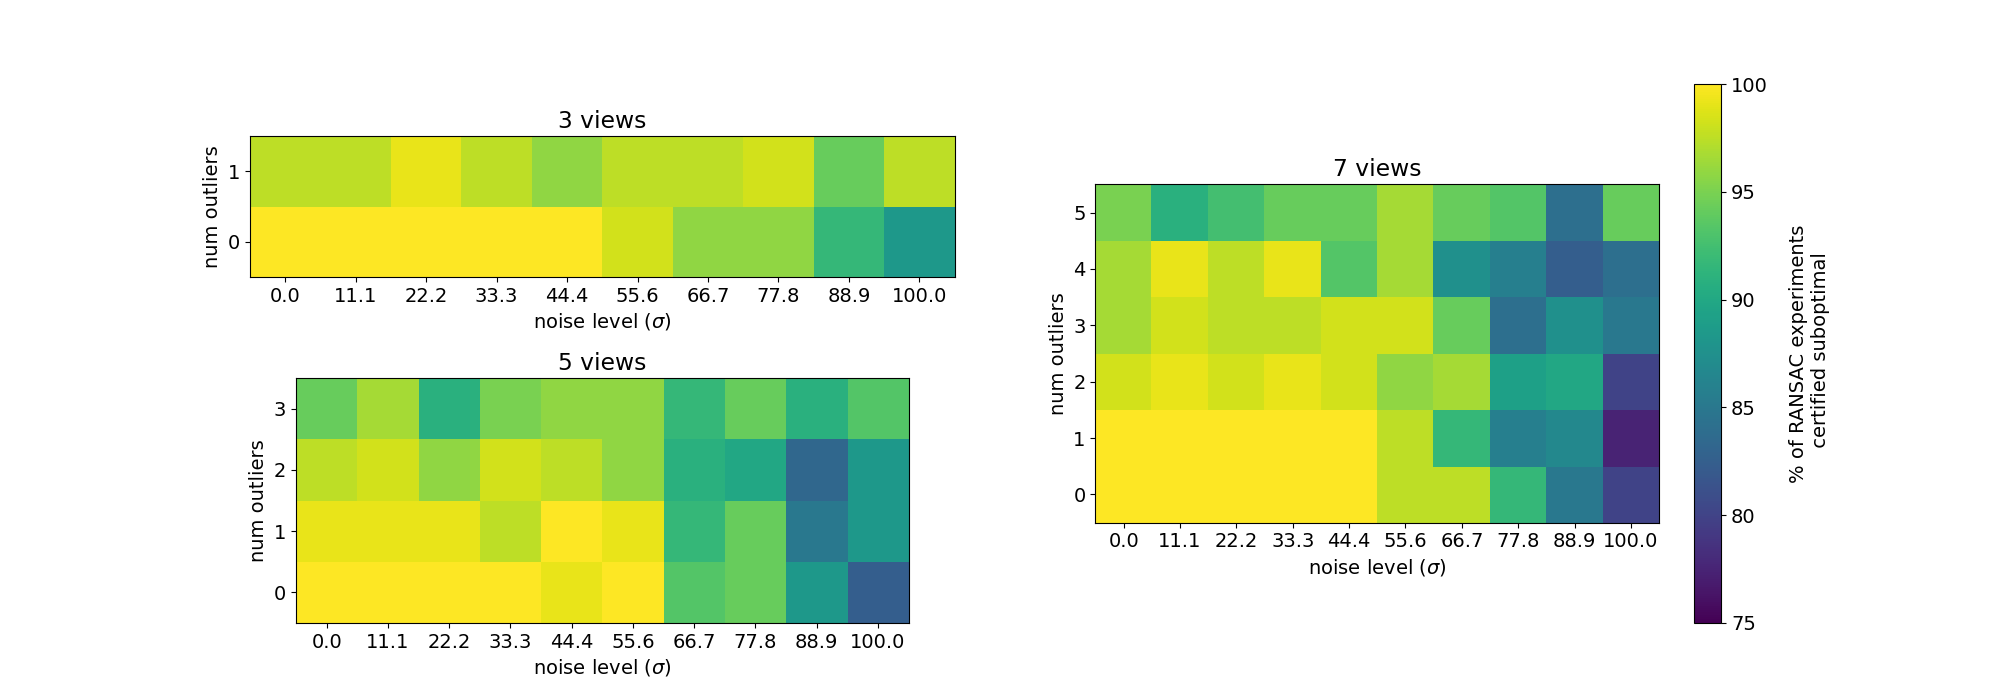

Saved session recovery to '/tmp/quit.blend'


: 

In [84]:
gridspec = matplotlib.gridspec.GridSpec(2, 2)
matplotlib.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(20, 7))
ax = [
    fig.add_subplot(gridspec[0, 0]),
    fig.add_subplot(gridspec[1, 0]),
    fig.add_subplot(gridspec[:, 1]),
]

for i in range(3):
    n_poses = sub_results.n_poses.unique()[i]
    ax[i].set_title(f'{n_poses} views')
    extent=(0,
            sub_results.observation_noise.max(),
            sub_results[sub_results.n_poses == n_poses].n_outliers.min(),
            sub_results[sub_results.n_poses == n_poses].n_outliers.max()
           )
    im = ax[i].imshow(t[i], origin="lower", vmin=75, vmax=100)
    ax[i].set_xticks(range(len(sub_results.observation_noise.unique())))
    tick_labels = [f'{d:.1f}' for d in sub_results.observation_noise.unique()]
    ax[i].set_xticklabels([tick_labels[int(i)] if 0 <= i < len(tick_labels) else '' for i in ax[i].get_xticks()])
    ax[i].set_yticks(range(n_poses - 1))

    ax[i].set_xlabel('noise level ($\sigma$)')
    ax[i].set_ylabel('num outliers')
cbar = fig.colorbar(im)
cbar.set_label('% of RANSAC experiments\n certified suboptimal', rotation=90, labelpad=15)